# Species Classification with Feed mechanism
- Kaggle의 Species dataset 분류
- read data process에 Feed mechanism 적용

### csv file
- csv file에서 filename 및 label 정보 불러오기

In [1]:
def read_labeled_image_list_from_csv(image_list_file, path, image_format):
    """Reads a .csv file containing pathes and labeles
    Args:
       image_list_file: a .txt file with one /path/to/image per line
       label: optionally, if set label will be pasted after each line
    Returns:
       List with all filenames in file image_list_file
    """
    f = open(image_list_file, 'r')
    filenames = []
    labels = []
    except_title = False
    for line in f:
        #print(line)
        if except_title:
            filename, label = line[:-1].split(',')
            filename = path + filename + '.' + image_format
            filenames.append(filename)
            labels.append(int(label))
        if except_title == False:
            except_title = True
            
    return filenames, labels

- train_labels.csv에서 training image name과 label 정보 가져오기
- validation_labels.csv에서 validation image name과 label 정보 가져오기

In [2]:
import tensorflow as tf

train_filename = '../Species/data/train_labels.csv'
validation_filename = '../Species/data/validation_labels.csv'

train_image_list, train_label_list = read_labeled_image_list_from_csv(train_filename,'../Species/data/train/' ,'jpg')
validation_image_list, validation_label_list = read_labeled_image_list_from_csv(validation_filename,'../Species/data/validation/' ,'jpg')

## Implement Feed machanism
- python code에서 numpy array로 이미지 load 및 resize
- ramdom.sample(batch_size)로 데이터 feeding

### PIL, scipy resize image
- image_list 경로의 이미지 불러오기

In [3]:
from scipy.misc import imresize
from PIL import Image
import numpy as np
%matplotlib inline

train_image_data_list = []
validation_image_data_list = []
for path in train_image_list:
    im = Image.open(path)
    im = np.array(im)
    im = imresize(im, (256, 256))
    train_image_data_list.append(im)

train_image_data_list = np.array(train_image_data_list)
    
for path in validation_image_list:
    im = Image.open(path)
    im = np.array(im)
    im = imresize(im, (256, 256))
    validation_image_data_list.append(im)
    
validation_image_data_list = np.array(validation_image_data_list)

## Data Augmentation
- imgaug를 이용한 data augmentation
- numpy.sample(batch_size)에서 출력된 결과 tensor(batch_size, 256, 256, 3)에 대해 연산

In [4]:
import imgaug as ia
from imgaug import augmenters as iaa

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -25 to +25 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 1.0
                    iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 5
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges
                #sometimes(iaa.OneOf([
                #    iaa.EdgeDetect(alpha=(0, 0.7)),
                #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                #])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                #iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 0.2)),
                sometimes(iaa.ElasticTransformation(alpha=(0.1, 1.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.03))) # sometimes move parts of the image around
            ],
            random_order=True
        )
    ],
    random_order=True
)

## Batch sampling
- np array에서 batch_size만큼 랜덤한 data sampling

In [5]:
import random
def get_batch(images, labels, batch_size):
    image_batch = []
    label_batch = []
    if len(images) != len(labels):
        print("error - lenth of images and labels are different!!")
        return None
    
    for i in range(batch_size):
        random_number = random.randrange(0, len(images))
        image_batch.append(images[random_number])
        label_batch.append(labels[random_number])
        
    image_batch = np.array(image_batch)
    label_batch = np.array(label_batch)
    return image_batch, label_batch

## Main Function

0 : time - 0.7907140254974365
[1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1]
validation: [0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0]
1 : time - 1.0165622234344482
[0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1]
2 : time - 0.6490929126739502
[1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0]
3 : time - 0.8951213359832764
[1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1]
4 : time - 0.6400468349456787
[0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1]
5 : time - 0.5484912395477295
[1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1]
validation: [1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0]
6 : time - 0.7837066650390625
[1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0]
7 : time - 0.8804428577423096
[0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1]
8 : time - 0.9564995765686035
[1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1

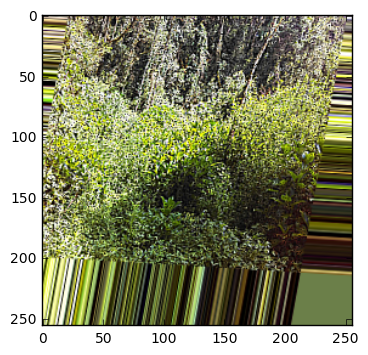

In [6]:
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
import time

num_epochs = None
batch_size = 32

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    
    # TensorBoard Summary 작성
    summaryWriter = tf.summary.FileWriter('../Species/log', graph=tf.get_default_graph())
    
    total_delay = 0
    for i in range(10):
        start_time = time.time()
        
        image_batch, label_batch = get_batch(train_image_data_list, train_label_list, batch_size)
        # Training data Augmentation
        image_batch_aug = seq.augment_images(image_batch)
        img = Image.fromarray(image_batch_aug[0], 'RGB')
        imshow(img)
        
        duration = time.time() - start_time
        print(i, ': time -', duration)
        
        #print(image_batch_aug)
        print(label_batch)
        
        total_delay += duration
        
        if i % 5 == 0:
            validation_image_batch, validation_label_batch = get_batch(validation_image_data_list, validation_label_list, batch_size)
            print("validation:", validation_label_batch)  
    print(total_delay)

# Conclusion
- Feed machanism conclusion : 10 times
- Feed machanism : 8.08